In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
# Create a simple LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Take only the output of the last time step
        out = self.fc(out)
        return out


In [3]:
# Prepare data for training
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [4]:
df = pd.read_csv('../data/MNQ DEC23.Last-500-Volume-Action.txt')
df.head()

,date,open,high,low,close,vol,ft,action
0,2023-10-02 22:00:38,14992.00,14992.25,14986.50,14989.50,500,-0.342828,0
1,2023-10-02 22:03:41,14989.75,14992.50,14988.25,14990.50,500,-0.062081,0
2,2023-10-02 22:08:04,14991.00,14992.75,14989.50,14992.00,500,0.396141,0
3,2023-10-02 22:13:26,14992.00,14995.00,14987.75,14989.75,500,0.204056,0
4,2023-10-02 22:14:44,14989.75,14999.00,14989.75,14997.50,500,0.449363,0


In [7]:
# Preprocess the data
scaler = StandardScaler()
prices_scaled = scaler.fit_transform(df[['close']].values)

In [8]:
seq_length = 52
X, y = create_sequences(prices_scaled, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [9]:
# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
# Hyperparameters
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001
batch_size = 128

# Initialize model, loss function, and optimizer
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [11]:
import tqdm

In [12]:
losses = []
# Training loop
for train_index, test_index in tqdm.tqdm_notebook(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert to DataLoader for easy batching
    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    for epoch in tqdm.tqdm_notebook(range(num_epochs), leave=False):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([61, 1, 1])) that is different to the input size (torch.Size([61, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0645
Epoch [20/100], Loss: 0.0557
Epoch [30/100], Loss: 0.0541
Epoch [40/100], Loss: 0.0509
Epoch [50/100], Loss: 0.0694
Epoch [60/100], Loss: 0.0593
Epoch [70/100], Loss: 0.0603
Epoch [80/100], Loss: 0.0547
Epoch [90/100], Loss: 0.0626
Epoch [100/100], Loss: 0.0636


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([117, 1, 1])) that is different to the input size (torch.Size([117, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.5454
Epoch [20/100], Loss: 0.5149
Epoch [30/100], Loss: 0.5099
Epoch [40/100], Loss: 0.5825
Epoch [50/100], Loss: 0.5410
Epoch [60/100], Loss: 0.5239
Epoch [70/100], Loss: 0.5512
Epoch [80/100], Loss: 0.5324
Epoch [90/100], Loss: 0.5253
Epoch [100/100], Loss: 0.5587


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([45, 1, 1])) that is different to the input size (torch.Size([45, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.3639
Epoch [20/100], Loss: 0.4569
Epoch [30/100], Loss: 0.5925
Epoch [40/100], Loss: 0.3501
Epoch [50/100], Loss: 0.3613
Epoch [60/100], Loss: 0.4303
Epoch [70/100], Loss: 0.4301
Epoch [80/100], Loss: 0.4453
Epoch [90/100], Loss: 0.5201
Epoch [100/100], Loss: 0.3553


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([101, 1, 1])) that is different to the input size (torch.Size([101, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.4739
Epoch [20/100], Loss: 0.4464
Epoch [30/100], Loss: 0.4975
Epoch [40/100], Loss: 0.4541
Epoch [50/100], Loss: 0.4146
Epoch [60/100], Loss: 0.4537
Epoch [70/100], Loss: 0.4136
Epoch [80/100], Loss: 0.3818
Epoch [90/100], Loss: 0.4857
Epoch [100/100], Loss: 0.4245


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29, 1, 1])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.8102
Epoch [20/100], Loss: 0.6600
Epoch [30/100], Loss: 0.7805
Epoch [40/100], Loss: 0.8776
Epoch [50/100], Loss: 0.6459
Epoch [60/100], Loss: 0.7720
Epoch [70/100], Loss: 0.5085
Epoch [80/100], Loss: 0.8974
Epoch [90/100], Loss: 1.1065
Epoch [100/100], Loss: 0.8108



In [13]:
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [14]:
model.eval()
with torch.no_grad():
    test_data = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

    predictions = []
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())


In [15]:
# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
y_test = y_test.reshape((-1,1))

In [16]:
predictions

array([[14936.91 ],
       [14936.902],
       [14936.916],
       ...,
       [14940.347],
       [14940.351],
       [14940.35 ]], dtype=float32)

In [17]:
y_test

array([[14296.25],
       [14302.  ],
       [14303.75],
       ...,
       [14756.  ],
       [14755.75],
       [14760.  ]], dtype=float32)

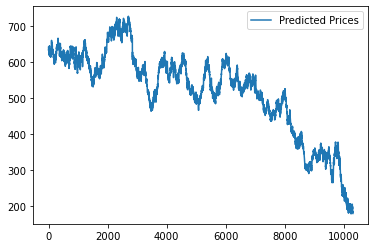

In [18]:
plt.plot((predictions - y_test).reshape((-1,)), label='Predicted Prices')
plt.legend()
plt.show()

Mean Squared Error on Test Data: 282789.2500


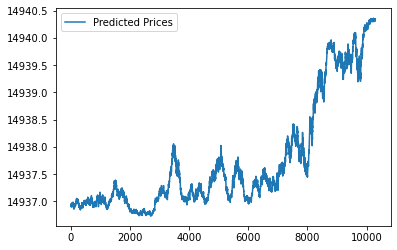

In [22]:
# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Data: {mse:.4f}')

# Plot the results
# plt.plot(y_test.reshape((-1,)), label='True Prices')
plt.plot(predictions.reshape((-1,)), label='Predicted Prices')
plt.legend()
plt.show()

Mean Squared Error on Test Data: 282789.2500


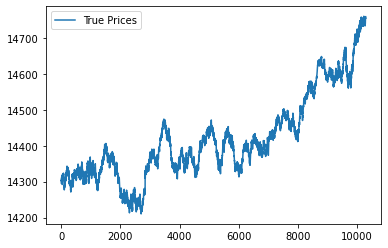

In [20]:
# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Data: {mse:.4f}')

# Plot the results
plt.plot(y_test.reshape((-1,)), label='True Prices')
# plt.plot(predictions.reshape((-1,)), label='Predicted Prices')
plt.legend()
plt.show()